In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *

Using TensorFlow backend.


Initialized TensorFlow


### Steps:
1. Train $M$ networks for each dropout on training $p\in[0,1]$
2. Get mean MAE on test/train for crash/nocrash. How does it behave? **Read papers where Dropout actually works for simple datasets. Do they use scaled or unscaled dropout?**
3. Get v1, v2, v3, v4 for each of the networks
4. Compute the rank loss if the networks were ordered by these bounds

In [2]:
# network configuration
N = [100, 50]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, p]  + [0] * len(N)

# prob. of failure at inference
p_inference = get_p_arr(0.05)

# prob. of failure at train
p_trains = np.linspace(0, 0.5, 10)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
repetitions = 2000

# number of runs for each p
runs = 20

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
print(len(x_train), len(x_test))

def get_dataset():
    keep_train, keep_test = 100, 50
    (x_train, y_train), (x_test, y_test) = boston_housing.load_data()
    x_train = x_train[:keep_train]
    y_train = y_train[:keep_train]
    x_test  = x_test[:keep_test]
    y_test  = y_test[:keep_test]
    return x_train, y_train, x_test, y_test

404 102


In [3]:
def get_results(p):
    # obtaining the distribution after 10 epochs
    results = []
    
    # current prob. of failure array
    p_train = get_p_arr(p)
    
    def unravel(name, data):
        return {name + '_train': data['train'], name + '_test': data['test']}
    
    for _ in tqdm(range(runs)):
        exp = TrainExperiment(*get_dataset(), N = N, p_inference = p_inference, p_train = p_train, KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = False,
                                      name = 'experiment_dropout', seed = None, batch_size = 10000)
        
        results += [{**unravel('correct_mae', exp.get_mae_correct()),
                     **unravel('crashing_mae', exp.get_mae_crash(repetitions = repetitions)),
                     'v2_var': np.mean(exp.get_bound_v2(exp.x_train)['std'] ** 2),
                     'v2_mean': np.mean(exp.get_bound_v2(exp.x_train)['mean']),
                     
                     'v3_var': np.mean(exp.get_bound_v3(exp.x_train)['std'] ** 2),
                     'v3_mean': np.mean(exp.get_bound_v3(exp.x_train)['mean']),
                               
                     'v4_var': np.mean(exp.get_bound_v4(exp.x_train)['std'] ** 2),
                     'v4_mean': np.mean(exp.get_bound_v4(exp.x_train)['mean']),
                    }]
        
    # list of all keys
    keys = list(results[0].keys())
    
    # return results
    return {key: [value[key] for value in results] for key in keys}

def process_results_single(results):
    for key, value in results.items():
        plt.figure()
        plt.title('%s: %.3f +- %.3f med %.3f' % (key, np.mean(value), np.std(value), np.median(value)))
        plt.hist(value)
        plt.xlabel(key)
        plt.show()

In [4]:
# obtaining results
results_array = [get_results(p) for p in p_trains]

100%|██████████| 20/20 [22:32<00:00, 70.29s/it]


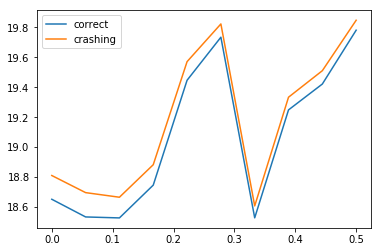

In [5]:
plt.figure()
plt.plot(p_trains, [np.mean(r['correct_mae_train']) for r in results_array], label = 'correct')
plt.plot(p_trains, [np.mean(r['crashing_mae_train']) for r in results_array], label = 'crashing')
plt.legend()

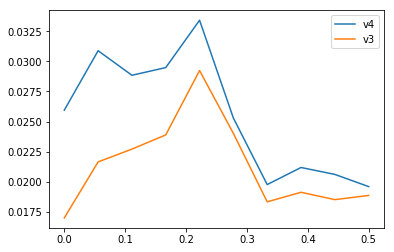

In [6]:
plt.figure()
plt.plot(p_trains, [np.mean(r['v4_var']) for r in results_array], label = 'v4')
plt.plot(p_trains, [np.mean(r['v3_var']) for r in results_array], label = 'v3')
plt.legend()